# Demonstration of bi-cross validation for spectral clustering

## basic example from sklearn website (with plotting added)

## Importing Libraries

In [1]:
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import manifold
from sklearn.manifold import spectral_embedding
from sklearn import svm
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state, check_array, check_symmetric
from sklearn.utils.extmath import _deterministic_vector_sign_flip
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import kneighbors_graph

from scipy import stats
from scipy import sparse
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh, lobpcg
from scipy.sparse.csgraph import connected_components
from scipy.sparse.csgraph import laplacian as csgraph_laplacian

from matplotlib import pyplot as plt
from importlib import reload

import scipy
import numpy as np


import warnings
import random
import itertools
import lib
import inspect

from lib import bi_cross_support
from lib import spectral_cluster_support
reload(spectral_cluster_support)


<module 'lib.spectral_cluster_support' from '/reg/neh/home5/sioan/Desktop/git_version_controlled/bcv_spectral_clustering/lib/spectral_cluster_support.py'>

## generating data set

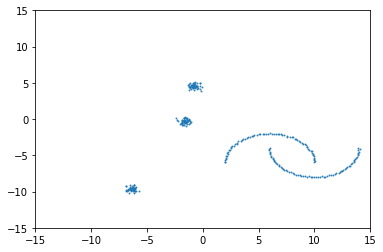

In [51]:
n_samples = 150
random_state = 140
n_centers = 3
X = datasets.make_blobs(n_samples=n_samples, centers = n_centers,n_features=2,random_state=11,cluster_std=0.3)[0]
X =np.vstack([X,np.array([6,-6])+4*datasets.make_moons(n_samples=n_samples, noise=.01)[0]])
plt.scatter(X[:,0],X[:,1],alpha=0.8,s=1)
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.show()

In [52]:
#n_samples = 150
#random_state = 170
#n_centers = 5
#X = datasets.make_blobs(n_samples=n_samples, centers = n_centers,n_features=2,cluster_std=0.35)[0]
#X = datasets.make_blobs(n_samples=n_samples, centers = n_centers,n_features=2,cluster_std=0.1+(np.random.rand(n_centers)**2)/10)[0]
#X =  datasets.make_moons(n_samples=n_samples, noise=.01)[0]
#plt.scatter(X[:,0],X[:,1],alpha=0.2)
#plt.xlim(-15,15)
#plt.ylim(-15,15)
#plt.show()

### Making sure clustering algorithm with correct number of centers clusters it correctly

In [53]:
spectral = cluster.SpectralClustering(n_clusters=5,
                                      assign_labels="discretize",
                                      random_state=0,
                                      gamma=1,
                                      #affinity = 'nearest_neighbors',
                                      affinity = 'rbf'
                                      #n_neighbors=8
                                      #gamma=1e2
                                     )
spectral.fit(X)

SpectralClustering(affinity='rbf', assign_labels='discretize', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1,
          kernel_params=None, n_clusters=5, n_init=10, n_jobs=None,
          n_neighbors=10, random_state=0)

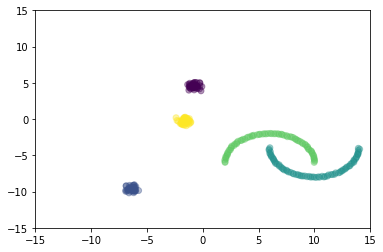

In [54]:
plt.scatter(X[:,0],X[:,1],c=spectral.labels_,alpha = 0.4)
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.show()

### validating the understanding of how spectral clustering works by applying  kmeans of eigen decomposed laplcian matrix

In [55]:
laplacian,my_embedding = lib.spectral_cluster_support.get_laplacian(spectral.affinity_matrix_,
                                #n_components = spectral.n_clusters,
                                n_components = 5,
                                drop_first=False, 
                                eigen_solver = spectral.eigen_solver,
                                random_state = spectral.random_state)

In [56]:
eig_vals, eig_vecs = np.linalg.eig(laplacian)
eig_vals, eig_vecs = np.real(eig_vals), np.real(eig_vecs)

In [57]:
kmeans = KMeans(n_clusters=5).fit(eig_vecs[:,np.argsort(np.abs(eig_vals))][:,:5])


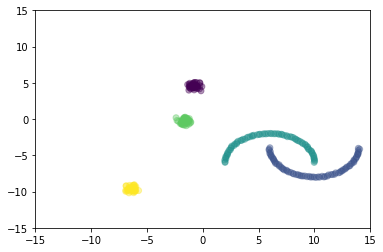

In [58]:
plt.scatter(X[:,0],X[:,1],c=kmeans.labels_,alpha = 0.4)
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.show()

## Calculating Bi-Cross Loss Function

In [64]:
spectral = cluster.SpectralClustering(n_clusters=2,                     #intentionally incorrect clusters
                                      assign_labels="discretize",
                                      #random_state=10,
                                      gamma=10.0,                        #this is important for the the 
                                      affinity = 'rbf')
spectral.fit(X)

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/py3-10-18/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(affinity='rbf', assign_labels='discretize', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=10.0,
          kernel_params=None, n_clusters=2, n_init=10, n_jobs=None,
          n_neighbors=10, random_state=None)

In [65]:
laplacian,my_embedding = lib.spectral_cluster_support.get_laplacian(spectral.affinity_matrix_,
                                #n_components = spectral.n_clusters,
                                n_components = X.shape[0]-2,
                                eigen_solver = spectral.eigen_solver,
                                random_state = spectral.random_state)

/reg/neh/home5/sioan/Desktop/git_version_controlled/bcv_spectral_clustering/lib/spectral_cluster_support.py:647: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [66]:
#x, y_stack = make_y_stack(.10,.015)         #for debugging: putting 0 yields expected behavior, but only with no shuffling
#y_stack = 0+np.linalg.inv(laplacian+0*np.random.rand(laplacian.shape[0],laplacian.shape[1]))
#y_stack = 0-laplacian
#y_stack = np.linalg.inv(laplacian - np.dot(np.linalg.inv(np.dot(my_embedding,my_embedding.transpose())),np.dot(np.dot(laplacian,my_embedding),my_embedding.transpose())))

#y_stack = 0+np.linalg.inv(laplacian+1e-6*stats.ortho_group.rvs(laplacian.shape[0]))

#this regularizer doesn't do much
#y_stack = np.linalg.inv(laplacian)

n_interations=10
row_range = range(laplacian.shape[0])
col_range = range(laplacian.shape[1])
MSE_list = []
min_k = 1
max_k = 16
k_range = np.arange(min_k,max_k)
regularization_parameter= 1e-14
#my_matrix = 0+ y_stack

def condition_matrix(X,regularization_magnitude):
    my_rand_mat = stats.ortho_group.rvs(X.shape[0])
    #my_rand_mat = my_rand_mat - np.dot(np.dot(np.linalg.inv(np.dot(my_rand_mat,my_rand_mat)), np.dot(my_rand_mat,X)),my_rand_mat)
    my_rand_mat = my_rand_mat - np.dot( np.dot(my_rand_mat.transpose(),X),my_rand_mat)
    
    #conditioned_laplacian = condition_matrix(laplacian,1e-3)
    #np.linalg.cond(conditioned_laplacian)
    
    return X + regularization_magnitude*my_rand_mat


for j in np.arange(n_interations):
    #y_stack = 0+np.linalg.inv(laplacian+regularization_parameter*stats.ortho_group.rvs(laplacian.shape[0]))   #this might be working
    #print(j)
    y_stack = np.linalg.inv(condition_matrix(laplacian,regularization_parameter))
    
    row_shuffling = np.array(random.sample(row_range,len(row_range)))     
    col_shuffling = np.array(random.sample(col_range,len(col_range)))
    
    my_matrix =  y_stack[row_shuffling]           #shuffling is messing things up, and it's not clear why
    my_matrix =  my_matrix[:,col_shuffling]
    #my_matrix = 0+ y_stack

    temp_MSE_list=[]
    
    for k in k_range:
    

        
        temp_MSE_list.append(bi_cross_support.score(my_matrix,
                                   k=k,
                                   d_n_rows=int(y_stack.shape[0]/2),
                                   d_n_cols=int(y_stack.shape[1]/2),
                                   SVD_package='numpy'))
        
    MSE_list.append(temp_MSE_list)

In [67]:
median_MSE_list = np.median(np.array(MSE_list),axis=0)
mean_MSE_list = np.mean(np.array(MSE_list),axis=0)
std_MSE_list = np.std(np.array(MSE_list),axis=0)/n_interations**0.5
print(k_range[np.argmin(median_MSE_list)])
print(k_range[np.argmin(mean_MSE_list)])

5
5


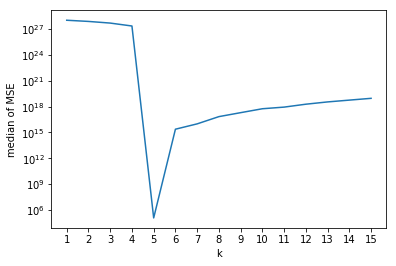

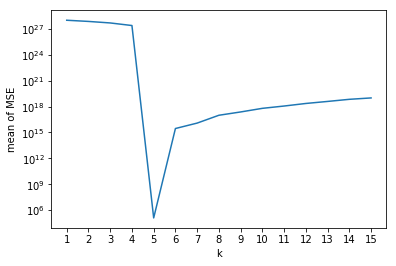

In [68]:
#plt.errorbar(np.arange(2,max_k),median_MSE_list,yerr=(std_MSE_list))
plt.semilogy(k_range,median_MSE_list)
#plt.ylim(0.9*np.min(median_MSE_list),1.25*np.min(median_MSE_list))
#plt.ylim(0,1e5)
plt.ylabel("median of MSE")
plt.xticks(k_range)
plt.xlabel("k")
plt.show()
plt.semilogy(k_range,mean_MSE_list)
#plt.errorbar(np.arange(2,max_k),mean_MSE_list,yerr=(std_MSE_list))
#plt.ylim(0.9*np.min(mean_MSE_list),1.25*np.min(mean_MSE_list))
plt.xticks(k_range)
plt.xlabel("k")
plt.ylabel("mean of MSE")
plt.show()

In [29]:
#it's very close to working.  The MSE of eigen predictor drops orders magnitude
#lot when it hits the right number of clusters

## putting into one big function to iterate over

In [34]:
def condition_matrix(X,regularization_magnitude):
    my_rand_mat = stats.ortho_group.rvs(X.shape[0])
    #my_rand_mat = my_rand_mat - np.dot(np.dot(np.linalg.inv(np.dot(my_rand_mat,my_rand_mat)), np.dot(my_rand_mat,X)),my_rand_mat)
    my_rand_mat = my_rand_mat - np.dot( np.dot(my_rand_mat.transpose(),X),my_rand_mat)
    
    #conditioned_laplacian = condition_matrix(laplacian,1e-3)
    #np.linalg.cond(conditioned_laplacian)
    
    return X + regularization_magnitude*my_rand_mat

def get_number_of_clusters(X,n_iterations,min_n_clusters,max_n_clusters,regularization_parameter,affinity):

    spectral = cluster.SpectralClustering(n_clusters=int(X.shape[0]/4),
                                          assign_labels="discretize",
                                          random_state=0,
                                          affinity = affinity,
                                          #n_neighbors=8
                                          #gamma=1e2
                                         )
    spectral.fit(X)

    laplacian,my_embedding = lib.spectral_cluster_support.get_laplacian(spectral.affinity_matrix_,
                                    #n_components = spectral.n_clusters,
                                    n_components = X.shape[0]-2,
                                    eigen_solver = spectral.eigen_solver,
                                    random_state = spectral.random_state)

    if type(laplacian)==scipy.sparse.csr.csr_matrix:
        laplacian=np.array(laplacian.todense())
    #print(type(laplacian))



    #y_stack = np.dot(laplacian,np.linalg.inv(np.dot(laplacian,laplacian.transpose())+0*1e-12*stats.ortho_group.rvs(laplacian.shape[0])))
    y_stack = np.linalg.inv(condition_matrix(laplacian,regularization_parameter))



    n_interations=n_iterations
    row_range = range(laplacian.shape[0])
    col_range = range(laplacian.shape[1])
    MSE_list = []
    min_k = min_n_clusters
    max_k = max_n_clusters
    k_range = np.arange(min_k,max_k)
    #my_matrix = 0+ y_stack

    for j in np.arange(n_interations):
        #y_stack = 0+np.linalg.inv(laplacian+1e-8*stats.ortho_group.rvs(laplacian.shape[0]))   #this might be working

        y_stack = np.linalg.inv(condition_matrix(laplacian,regularization_parameter))

        #print(j)
        row_shuffling = np.array(random.sample(row_range,len(row_range)))     
        col_shuffling = np.array(random.sample(col_range,len(col_range)))

        my_matrix =  y_stack[row_shuffling]           #shuffling is messing things up, and it's not clear why
        my_matrix =  my_matrix[:,col_shuffling]
        #my_matrix = 0+ y_stack

        temp_MSE_list=[]

        for k in k_range:



            temp_MSE_list.append(bi_cross_support.score(my_matrix,
                                       k=k,
                                       d_n_rows=int(y_stack.shape[0]/2),
                                       d_n_cols=int(y_stack.shape[1]/2),
                                       SVD_package='numpy'))

        MSE_list.append(temp_MSE_list)

        
    #MSE_list = np.array([np.array(i) for i in MSE_list])
    median_MSE_list = np.median(np.array(MSE_list),axis=0)
    mean_MSE_list = np.mean(np.array(MSE_list),axis=0)
    std_MSE_list = np.std(np.array(MSE_list),axis=0)/n_interations**0.5
   
    
    #return median_MSE_list,mean_MSE_list,std_MSE_list
    return 1.0/np.linalg.cond(y_stack), k_range,median_MSE_list,mean_MSE_list,std_MSE_list

## Making sample data and running function

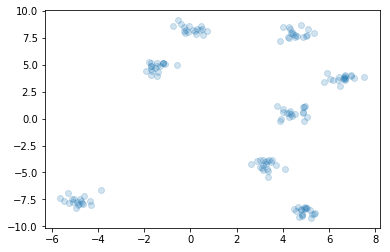

In [35]:
n_samples = 150
random_state = 170
n_centers = 8
regularization_parameter = 1e-9
X = datasets.make_blobs(n_samples=n_samples, centers = n_centers,n_features=2,cluster_std=0.4)[0]
#X = datasets.make_blobs(n_samples=n_samples, centers = n_centers,n_features=2,cluster_std=0.1+(np.random.rand(n_centers)**2)/10)[0]
#X =  datasets.make_moons(n_samples=n_samples, noise=.01)[0]
plt.scatter(X[:,0],X[:,1],alpha=0.2)
plt.show()

In [36]:
#temp = get_number_of_clusters(X,n_iterations=100,min_n_clusters=1,max_n_clusters=20,regularization_parameter=1e-9)
condition_number,k_range,median_MSE_list,mean_MSE_list,std_MSE_list = get_number_of_clusters(X,
                                                                            n_iterations=100,
                                                                            min_n_clusters=1,
                                                                            max_n_clusters=30,
                                                                            regularization_parameter=1e-9,
                                                                            affinity = 'rbf' #'rbf or nearest_neighbors'
                                                                            )
print(k_range[np.argmin(median_MSE_list)])
print(k_range[np.argmin(mean_MSE_list)])

8
8


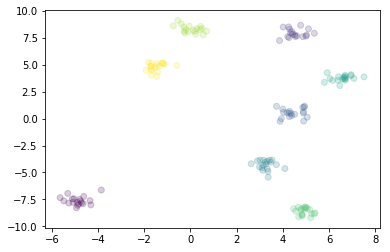

In [37]:
spectral = cluster.SpectralClustering(k_range[np.argmin(median_MSE_list)],
                                      assign_labels="discretize",
                                      #random_state=0,
                                      #affinity = 'nearest_neighbors',
                                      #n_neighbors=8
                                      #gamma=1e2
                                     )
spectral.fit(X)

plt.scatter(X[:,0],X[:,1],alpha=0.2,c=spectral.labels_)
plt.show()

In [38]:
def make_plots(k_range,median_MSE_list,mean_MSE_list):
    #plt.errorbar(np.arange(2,max_k),median_MSE_list,yerr=(std_MSE_list))
    plt.semilogy(k_range,median_MSE_list)
    #plt.ylim(0.9*np.min(median_MSE_list),1.25*np.min(median_MSE_list))
    #plt.ylim(0,1e5)
    plt.ylabel("median of MSE")
    plt.xticks(k_range)
    plt.xlabel("k")
    #plt.show()
    plt.semilogy(k_range,mean_MSE_list)
    #plt.errorbar(np.arange(2,max_k),mean_MSE_list,yerr=(std_MSE_list))
    #plt.ylim(0.9*np.min(mean_MSE_list),1.25*np.min(mean_MSE_list))
    plt.xticks(k_range)
    plt.xlabel("k")
    plt.ylabel("mean of MSE")
    plt.show()

In [39]:
condition_number

9.804721318218016e-10

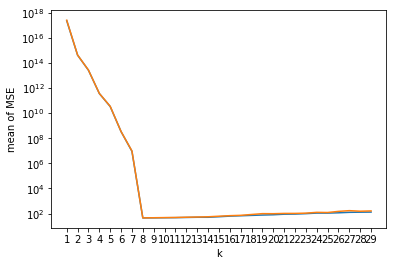

In [40]:
make_plots(k_range,median_MSE_list,mean_MSE_list)

## Systematic investigations


### changing regularization parameter and monitoring the condition number for different number of clusters for two dimensions

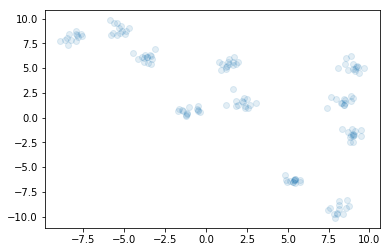

In [56]:
n_samples = 150
random_state = 170
n_centers = 11
regularization_parameter = 1e-9
X = datasets.make_blobs(n_samples=n_samples, centers = n_centers,n_features=2,cluster_std=0.4,random_state=151)[0]
#X = datasets.make_blobs(n_samples=n_samples, centers = n_centers,n_features=2,cluster_std=0.1+(np.random.rand(n_centers)**2)/10)[0]
#X =  datasets.make_moons(n_samples=n_samples, noise=.01)[0]
plt.scatter(X[:,0],X[:,1],alpha=0.12)
plt.show()


spectral = cluster.SpectralClustering(4,
                                      assign_labels="discretize",
                                      #random_state=0,
                                      #affinity = 'nearest_neighbors',
                                      #n_neighbors=8
                                      #gamma=1e2
                                     )
spectral.fit(X)

laplacian,my_embedding = lib.spectral_cluster_support.get_laplacian(spectral.affinity_matrix_,
                                    #n_components = spectral.n_clusters,
                                    n_components = 55,
                                    eigen_solver = 'lobpcg',
                                    #random_state = spectral.random_state
                                    )

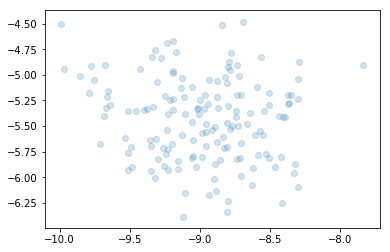

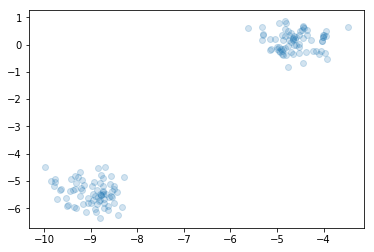

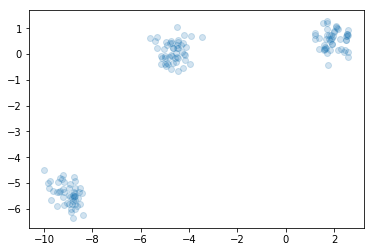

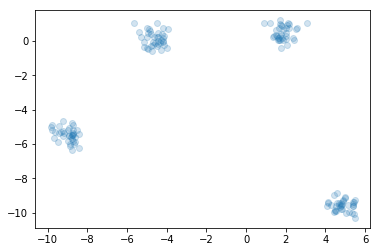

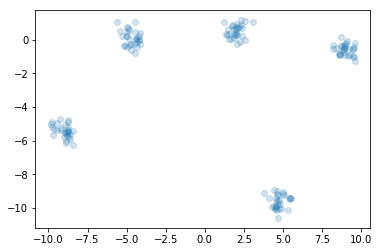

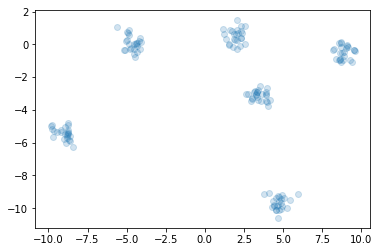

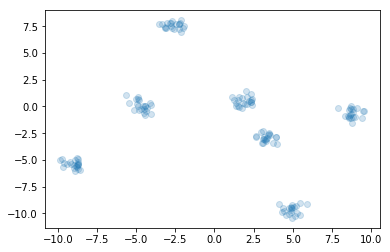

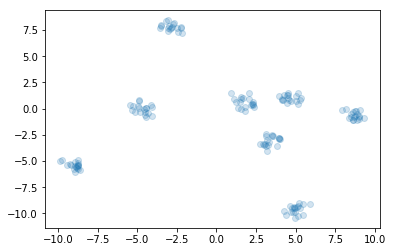

In [57]:
my_dict = {}
#regularization_parameter_list = 10.0**np.arange(-19,-4)
regularization_parameter_list = [1e-7,3e-8,7e-8,1.0e-8,7e-9,1.0e-9,3e-9,7e-9,1.0e-10,3e-10,7e-10,7e-11,3e-11,1.0e-11,1e-12]
#n_cluster_list = [2,3,4,5,6,7,8]
n_cluster_list = [1,2,3,4,5,6,7,8]

n_iterations = 100


for j in n_cluster_list:
    
    my_dict[j,'condition_number'] = []
    my_dict[j,'regularization_parameter'] = []
    my_dict[j,'means'] = []
    my_dict[j,'medians'] = []
    
    
    n_samples = 150
    random_state = 170
    n_centers = j
    X = datasets.make_blobs(n_samples=n_samples, centers = n_centers,n_features=2,cluster_std=0.4,random_state=170)[0]
    #X = datasets.make_blobs(n_samples=n_samples, centers = n_centers,n_features=2,cluster_std=0.1+(np.random.rand(n_centers)**2)/10)[0]
    #X =  datasets.make_moons(n_samples=n_samples, noise=.01)[0]
    plt.scatter(X[:,0],X[:,1],alpha=0.2)
    plt.show()


    for i in regularization_parameter_list:
        
        regularization_parameter = i
        condition_number,k_range,median_MSE_list,mean_MSE_list,std_MSE_list = get_number_of_clusters(X,
                                                                                    n_iterations=n_iterations,
                                                                                    min_n_clusters=1,
                                                                                    max_n_clusters=20,
                                                                                    regularization_parameter=regularization_parameter,
                                                                                    affinity = 'rbf' #'rbf or nearest_neighbors'
                                                                                    )

        my_dict[j,'condition_number'].append(condition_number)
        my_dict[j,'regularization_parameter'].append(i)
        my_dict[j,'means'].append(mean_MSE_list)
        my_dict[j,'medians'].append(median_MSE_list)

        #make_plots(k_range,median_MSE_list,mean_MSE_list)

1


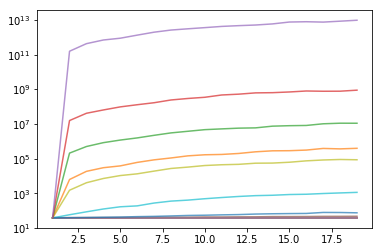

2


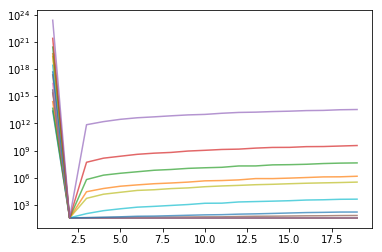

3


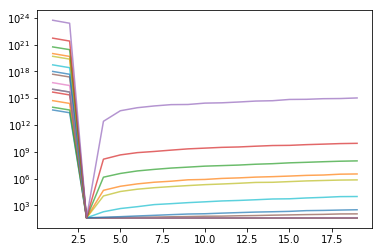

4


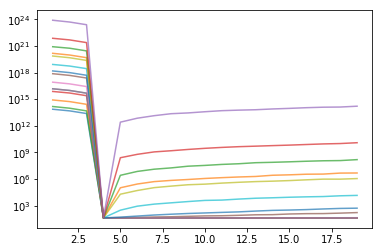

5


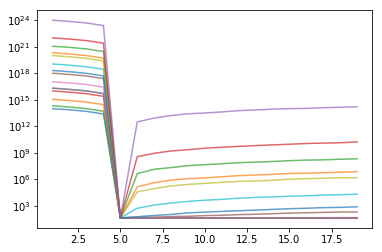

6


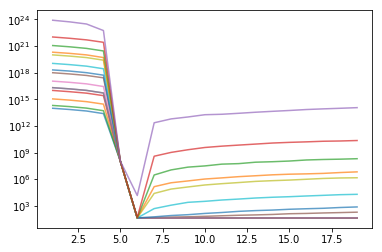

7


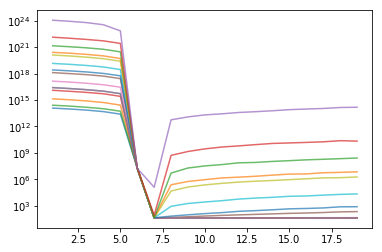

8


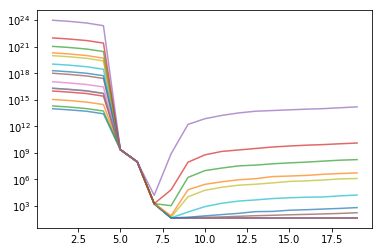

In [58]:
for j in n_cluster_list:
    print(j)

    for i in range(len(my_dict[j,'medians'])):
        plt.semilogy(k_range, my_dict[j,'medians'][i],'-',alpha=0.7)

    plt.show()

### higher number of dimensions (8)

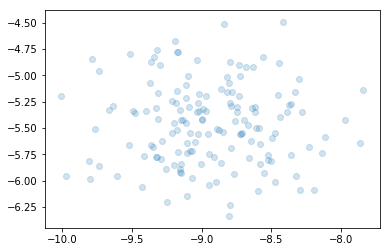

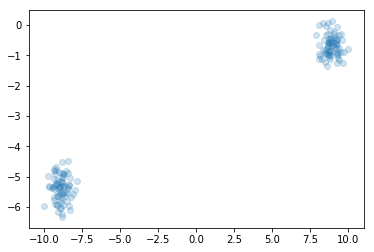

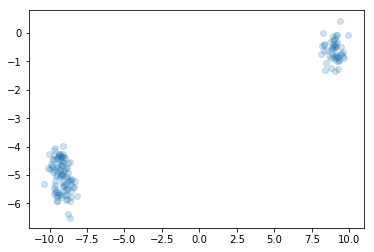

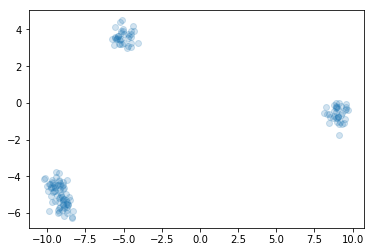

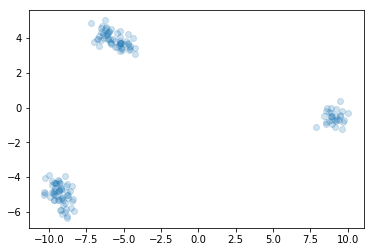

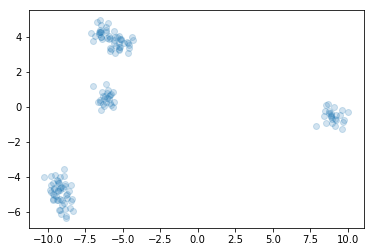

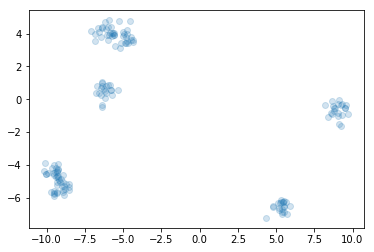

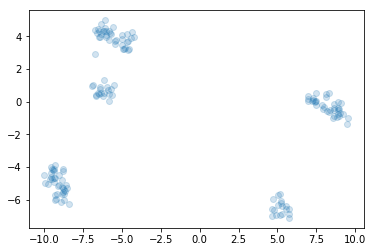

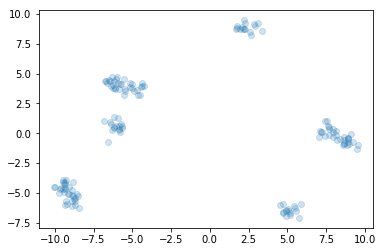

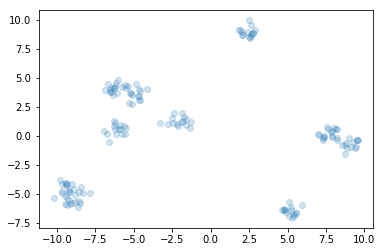

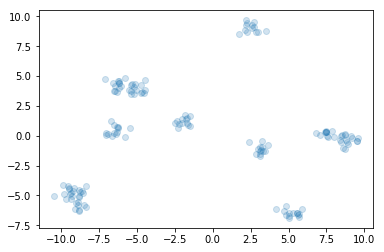

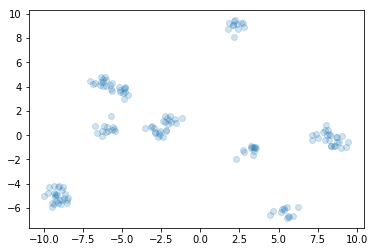

In [65]:
my_dict = {}
#regularization_parameter_list = 10.0**np.arange(-19,-4)
regularization_parameter_list = [1e-7,3e-8,7e-8,1.0e-8,7e-9,1.0e-9,3e-9,7e-9,1.0e-10,3e-10,7e-10,7e-11,3e-11,1.0e-11,1e-12]
#n_cluster_list = [2,3,4,5,6,7,8]
n_cluster_list = [1,2,3,4,5,6,7,8,9,10,11,12]

my_iterator = itertools.product(regularization_parameter_list,n_cluster_list)
n_iterations = 100


for j in n_cluster_list:
    
    my_dict[j,'condition_number'] = []
    my_dict[j,'regularization_parameter'] = []
    my_dict[j,'means'] = []
    my_dict[j,'medians'] = []
    
    
    n_samples = 150
    random_state = 170
    n_centers = j
    X = datasets.make_blobs(n_samples=n_samples, centers = n_centers,n_features=8,cluster_std=0.4,random_state=170)[0]
    #X = datasets.make_blobs(n_samples=n_samples, centers = n_centers,n_features=2,cluster_std=0.1+(np.random.rand(n_centers)**2)/10)[0]
    #X =  datasets.make_moons(n_samples=n_samples, noise=.01)[0]
    plt.scatter(X[:,0],X[:,1],alpha=0.2)
    plt.show()


    for i in regularization_parameter_list:
        
        regularization_parameter = i
        condition_number,k_range,median_MSE_list,mean_MSE_list,std_MSE_list = get_number_of_clusters(X,
                                                                                    n_iterations=n_iterations,
                                                                                    min_n_clusters=1,
                                                                                    max_n_clusters=20,
                                                                                    regularization_parameter=regularization_parameter,
                                                                                    affinity = 'rbf' #'rbf or nearest_neighbors'
                                                                                    )

        my_dict[j,'condition_number'].append(condition_number)
        my_dict[j,'regularization_parameter'].append(i)
        my_dict[j,'means'].append(mean_MSE_list)
        my_dict[j,'medians'].append(median_MSE_list)

        #make_plots(k_range,median_MSE_list,mean_MSE_list)

1


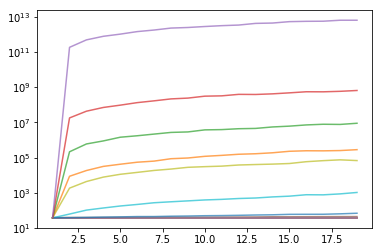

2


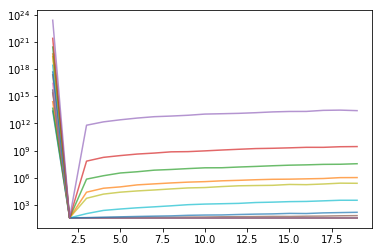

3


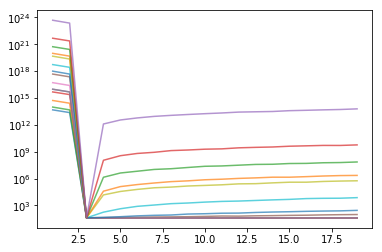

4


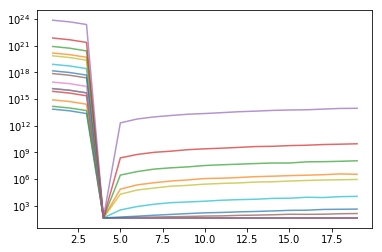

5


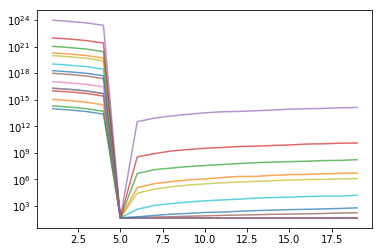

6


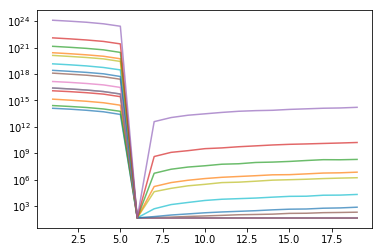

7


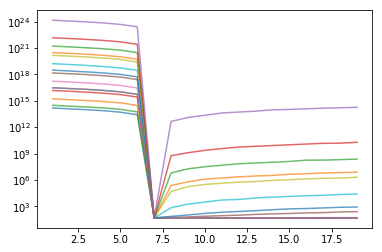

8


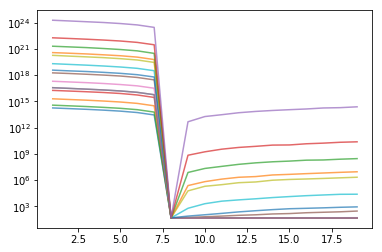

9


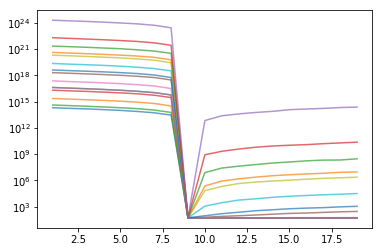

10


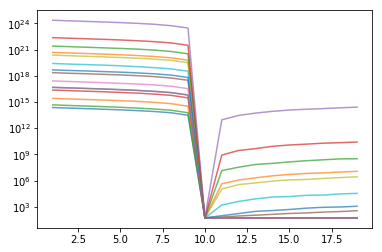

11


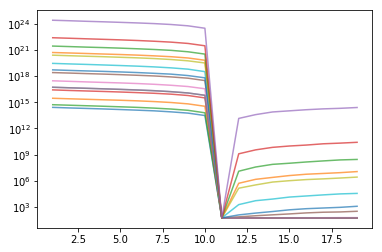

12


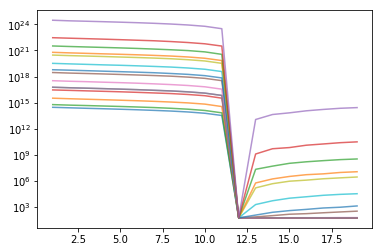

In [66]:
for j in n_cluster_list:
    print(j)

    for i in range(len(my_dict[j,'medians'])):
        plt.semilogy(k_range, my_dict[j,'medians'][i],'-',alpha=0.7)

    plt.show()

1


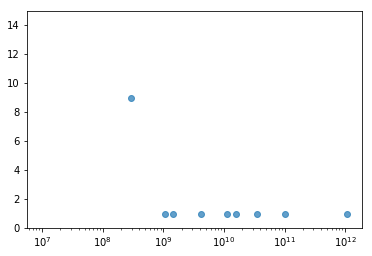

2


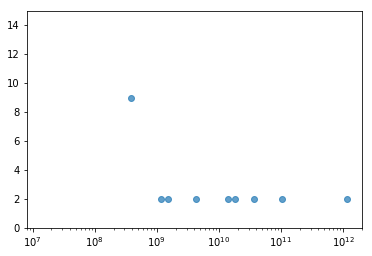

3


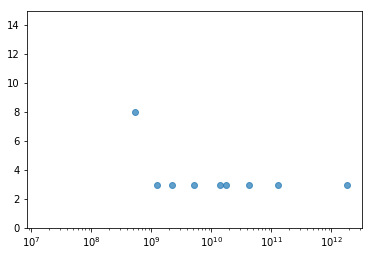

4


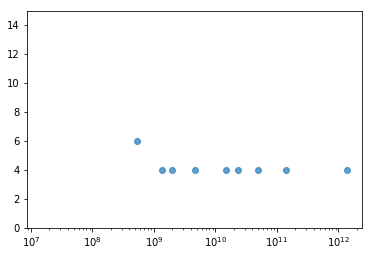

5


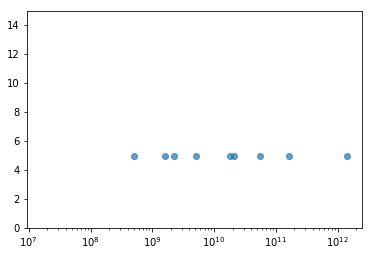

6


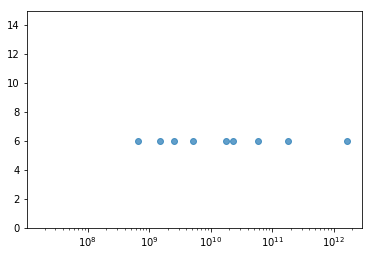

7


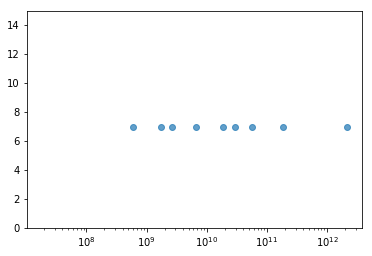

8


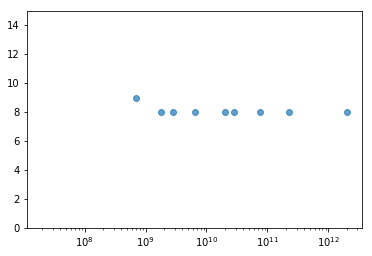

9


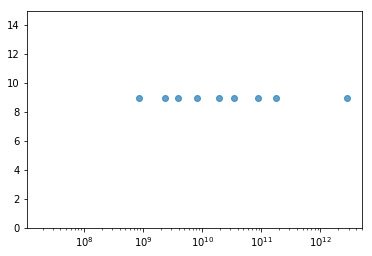

10


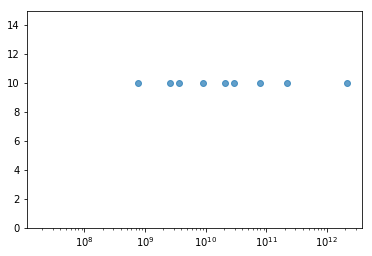

11


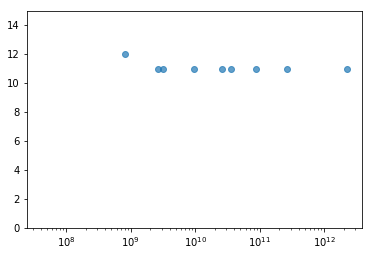

12


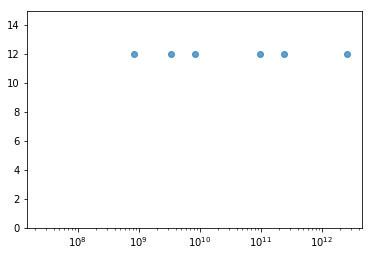

In [67]:
for j in n_cluster_list:
    print(j)
    plt.semilogx(1.0/np.array(my_dict[j,'condition_number']), 
                 k_range[np.argmin(my_dict[j,'means'],axis=1)],
                 'o',alpha=0.7)
    plt.ylim(0,15)
    plt.show()

1


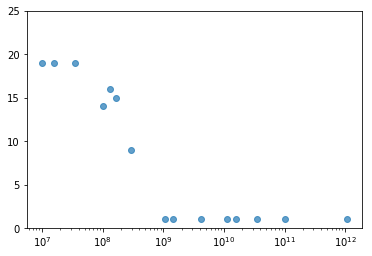

2


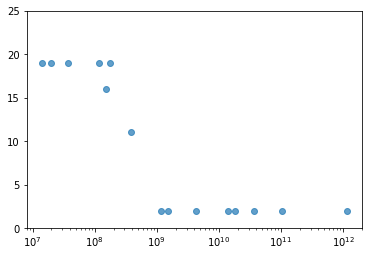

3


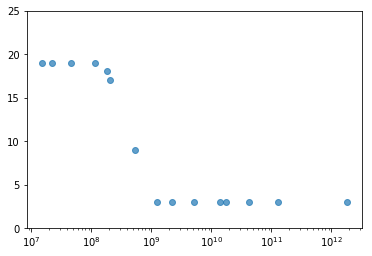

4


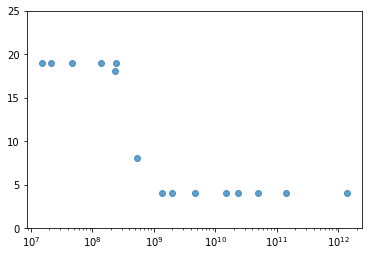

5


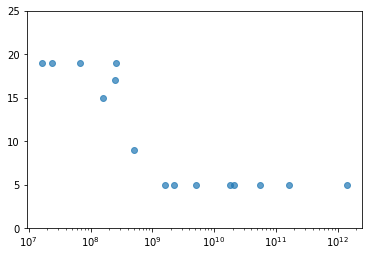

6


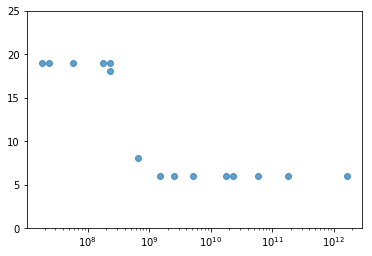

7


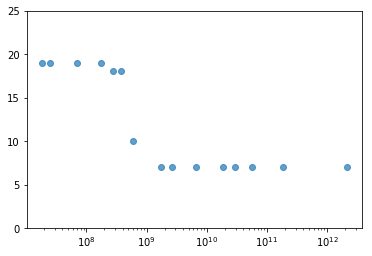

8


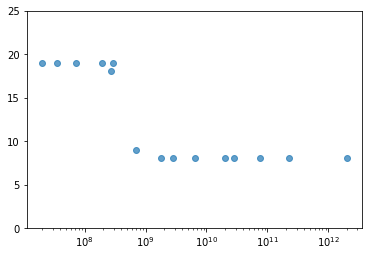

9


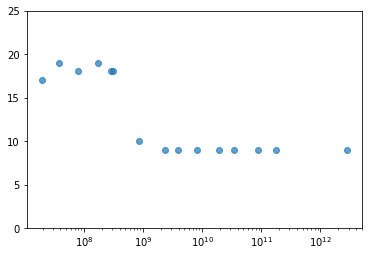

10


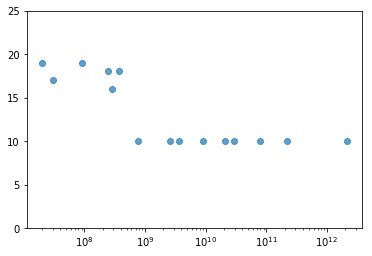

11


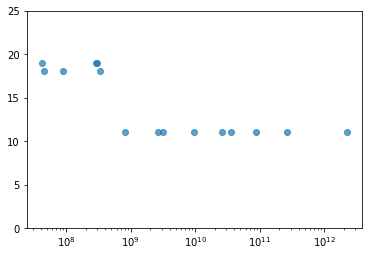

12


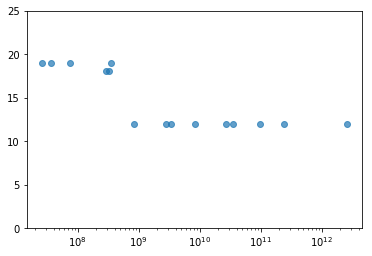

In [68]:
for j in n_cluster_list:
    print(j)
    plt.semilogx(1.0/np.array(my_dict[j,'condition_number']), 
                 k_range[np.argmin(my_dict[j,'medians'],axis=1)],
                 'o',alpha=0.7)
    plt.ylim(0,25)
    plt.show()

### iterating over number of dimensions

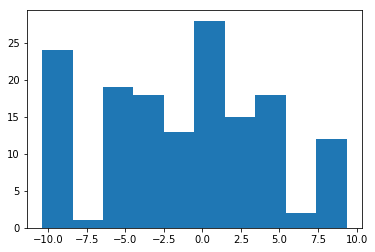

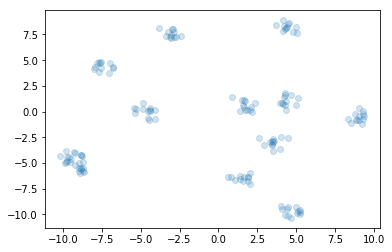

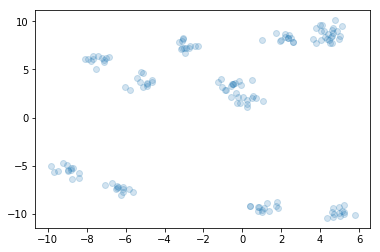

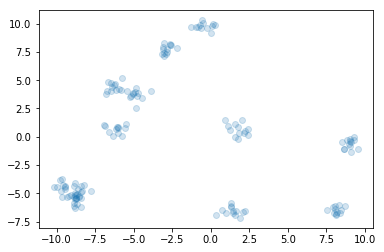

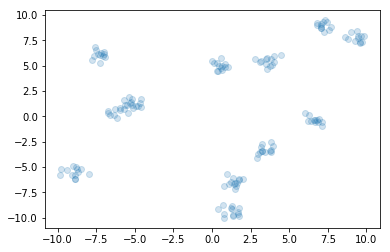

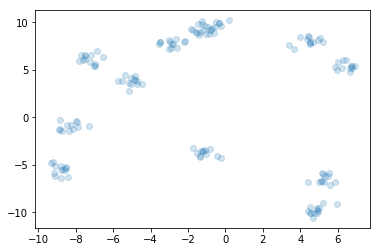

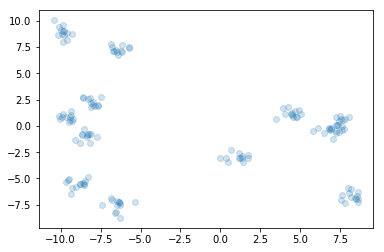

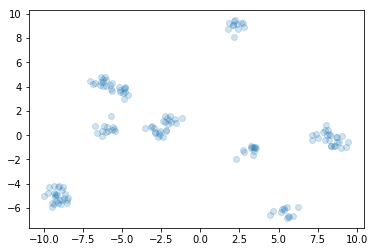

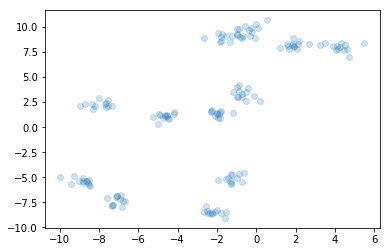

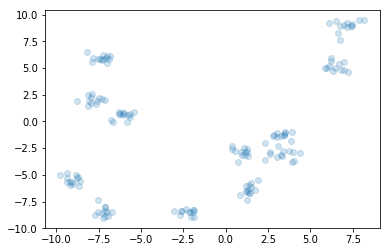

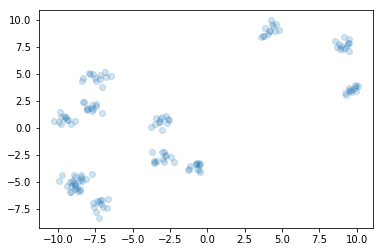

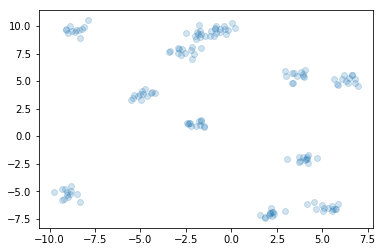

In [69]:
my_dict = {}
#regularization_parameter_list = 10.0**np.arange(-19,-4)
regularization_parameter_list = [1e-7,3e-8,7e-8,1.0e-8,7e-9,1.0e-9,3e-9,7e-9,1.0e-10,3e-10,7e-10,7e-11,3e-11,1.0e-11,1e-12]
#n_cluster_list = [2,3,4,5,6,7,8]
n_feature_list = [1,2,3,4,5,6,7,8,9,10,11,12]

my_iterator = itertools.product(regularization_parameter_list,n_cluster_list)
n_iterations = 100


for j in n_feature_list:
    
    my_dict[j,'condition_number'] = []
    my_dict[j,'regularization_parameter'] = []
    my_dict[j,'means'] = []
    my_dict[j,'medians'] = []
    
    
    n_samples = 150
    random_state = 170
    n_centers = 12
    random_state=170
    cluster_std=0.4
    
    n_features = j
    
    X = datasets.make_blobs(n_samples=n_samples, centers = n_centers,n_features=n_features,cluster_std=cluster_std,random_state=random_state)[0]
    #X = datasets.make_blobs(n_samples=n_samples, centers = n_centers,n_features=2,cluster_std=0.1+(np.random.rand(n_centers)**2)/10)[0]
    #X =  datasets.make_moons(n_samples=n_samples, noise=.01)[0]
    try:
        plt.scatter(X[:,0],X[:,1],alpha=0.2)
        plt.show()
    except IndexError:
        
        plt.hist(X[:,0])
        plt.show()

    for i in regularization_parameter_list:
        
        regularization_parameter = i
        condition_number,k_range,median_MSE_list,mean_MSE_list,std_MSE_list = get_number_of_clusters(X,
                                                                                    n_iterations=n_iterations,
                                                                                    min_n_clusters=1,
                                                                                    max_n_clusters=20,
                                                                                    regularization_parameter=regularization_parameter,
                                                                                    affinity = 'rbf' #'rbf or nearest_neighbors'
                                                                                    )

        my_dict[j,'condition_number'].append(condition_number)
        my_dict[j,'regularization_parameter'].append(i)
        my_dict[j,'means'].append(mean_MSE_list)
        my_dict[j,'medians'].append(median_MSE_list)

        #make_plots(k_range,median_MSE_list,mean_MSE_list)

1


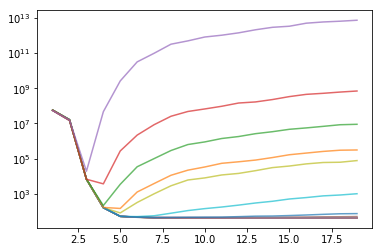

2


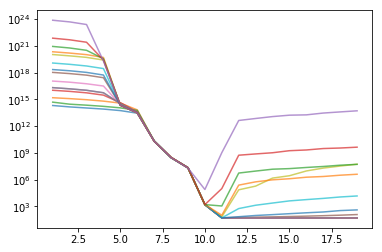

3


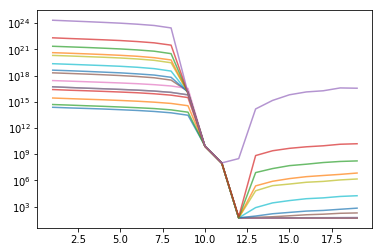

4


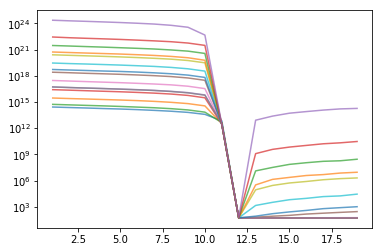

5


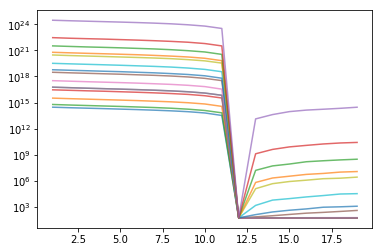

6


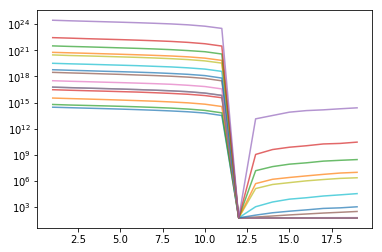

7


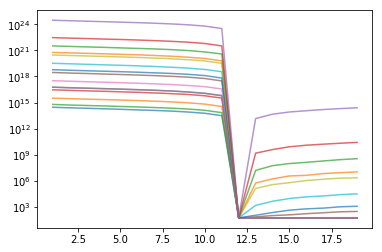

8


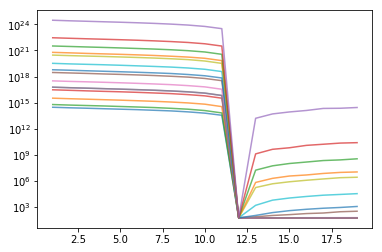

9


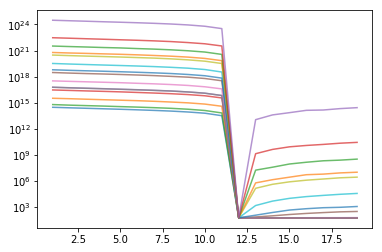

10


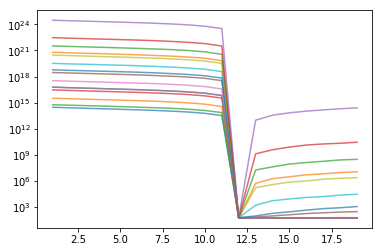

11


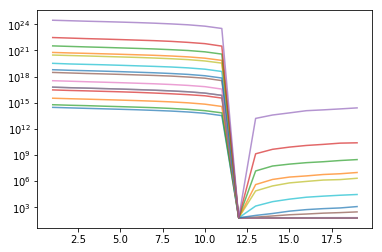

12


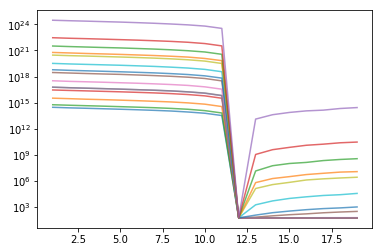

In [70]:
for j in n_feature_list:
    print(j)

    for i in range(len(my_dict[j,'medians'])):
        plt.semilogy(k_range, my_dict[j,'medians'][i],'-',alpha=0.7)

    plt.show()

1


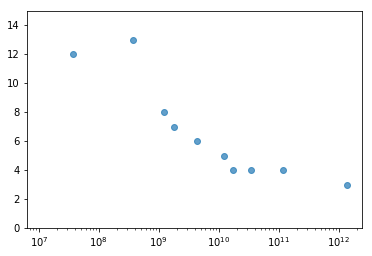

2


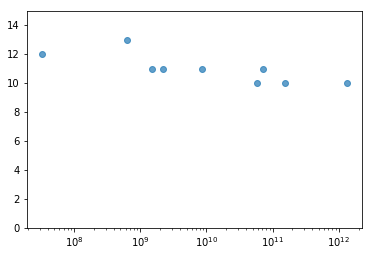

3


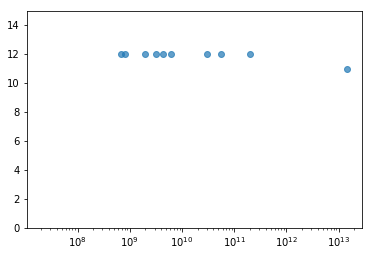

4


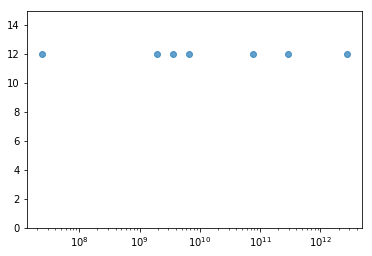

5


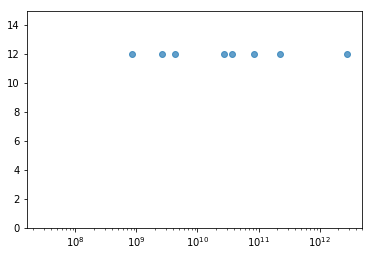

6


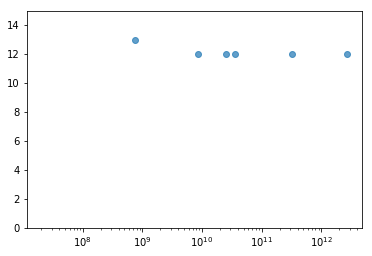

7


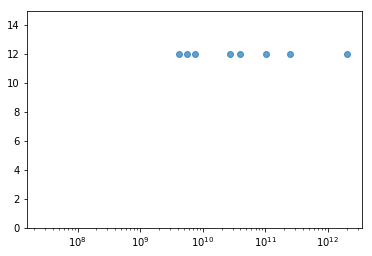

8


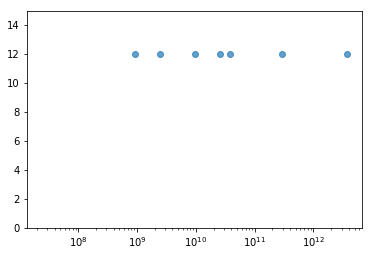

9


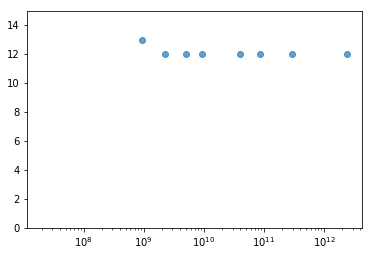

10


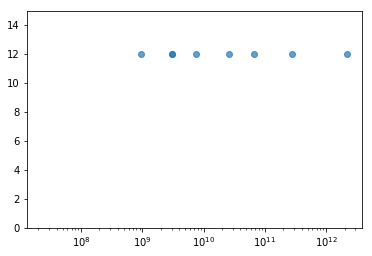

11


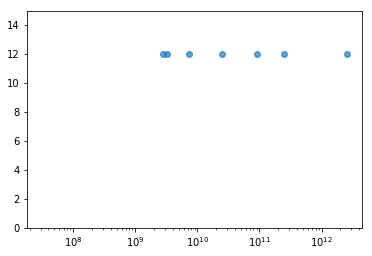

12


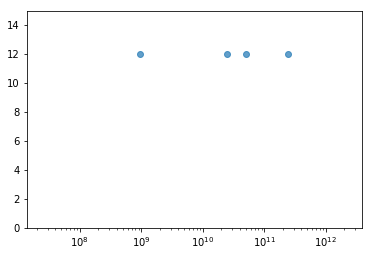

In [71]:
for j in n_feature_list:
    print(j)
    plt.semilogx(1.0/np.array(my_dict[j,'condition_number']), 
                 k_range[np.argmin(my_dict[j,'means'],axis=1)],
                 'o',alpha=0.7)
    plt.ylim(0,15)
    plt.show()

### iterating over standard deviation